In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
!pip install matplotlib --quiet
!pip install -U aeon --quiet
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
#from aeon.transformations.collection.convolution_based._rocket import Rocket #from aeon.transformations.collection.rocket import Rocket mudou
from aeon.transformations.collection.convolution_based._rocket import * #importa tudo oq esta dentro do rocket
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [ ]:
from aeon.datasets._data_loaders import load_classification
from aeon.datasets.tsc_data_lists import univariate_equal_length as dataset_list

In [ ]:
#dataset 1: ECG200
x_train, y_train = load_classification("CinCECGTorso", split='train')
x_test, y_test = load_classification("CinCECGTorso", split='test')
rck = Rocket(num_kernels=10000)

x_train_feat = rck.fit_transform(x_train)
x_test_feat = rck.fit_transform(x_test)

x_transformado = rck._transform(x_train) #matriz transformada com ppv(pares) e max(ímpares)

In [ ]:
x_train_feat.shape

(40, 20000)

In [ ]:
# ppv (começa em 0, vai até o final, pula de 2 em 2)
x_transformado[:,::2]

array([[0.1760707 , 0.94897324, 0.39536303, ..., 0.195241  , 0.6969697 ,
        0.7364246 ],
       [0.267845  , 0.93030494, 0.3965833 , ..., 0.11958511, 0.7070707 ,
        0.49359366],
       [0.24337186, 0.9396391 , 0.46125686, ..., 0.14704087, 0.7737374 ,
        0.5594875 ],
       ...,
       [0.27872196, 0.9520846 , 0.39231238, ..., 0.17815742, 0.589899  ,
        0.6247712 ],
       [0.2182189 , 0.92657125, 0.4514948 , ..., 0.21232459, 0.7030303 ,
        0.6247712 ],
       [0.2950374 , 0.9495955 , 0.40939596, ..., 0.18364857, 0.53535354,
        0.59548503]], dtype=float32)

In [ ]:
x_transformado[:,1::2] # max

array([[ 7.2178454, 26.037533 , 10.364158 , ..., 31.769915 , 13.660154 ,
        25.335833 ],
       [ 6.0010138, 15.106749 ,  8.430486 , ..., 21.639795 , 14.237504 ,
        13.767778 ],
       [ 7.454812 , 10.863623 ,  8.715763 , ..., 19.376019 ,  6.1969085,
        12.517037 ],
       ...,
       [ 7.3975835, 13.8676815,  9.425294 , ..., 21.889088 , 21.651575 ,
        16.048115 ],
       [ 5.962097 ,  9.772361 ,  7.1405554, ..., 17.52063  , 10.23926  ,
        13.7840605],
       [ 5.8760314, 14.050602 ,  9.353782 , ..., 23.0806   , 22.299892 ,
        13.9790325]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

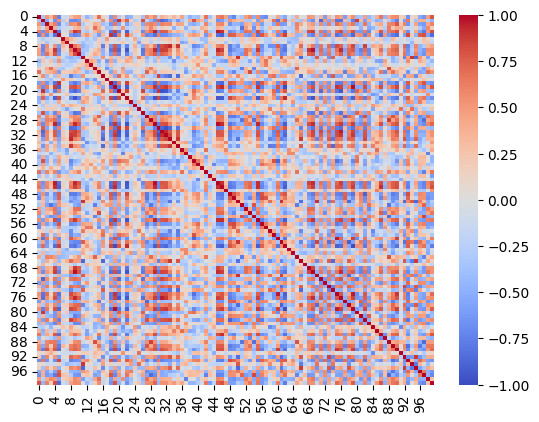

In [ ]:
#Análise dos valores do ppv
correlation_matrix1 = np.corrcoef(x_transformado[:,0:200:2].T)#seleciona todas as linhas, colunas de 0 a 36 pulando de 2 em 2(0,2,4,6,..., pares valores PPV)
sns.heatmap(correlation_matrix1, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

In [ ]:
np.min(correlation_matrix1)

-0.988207978707108

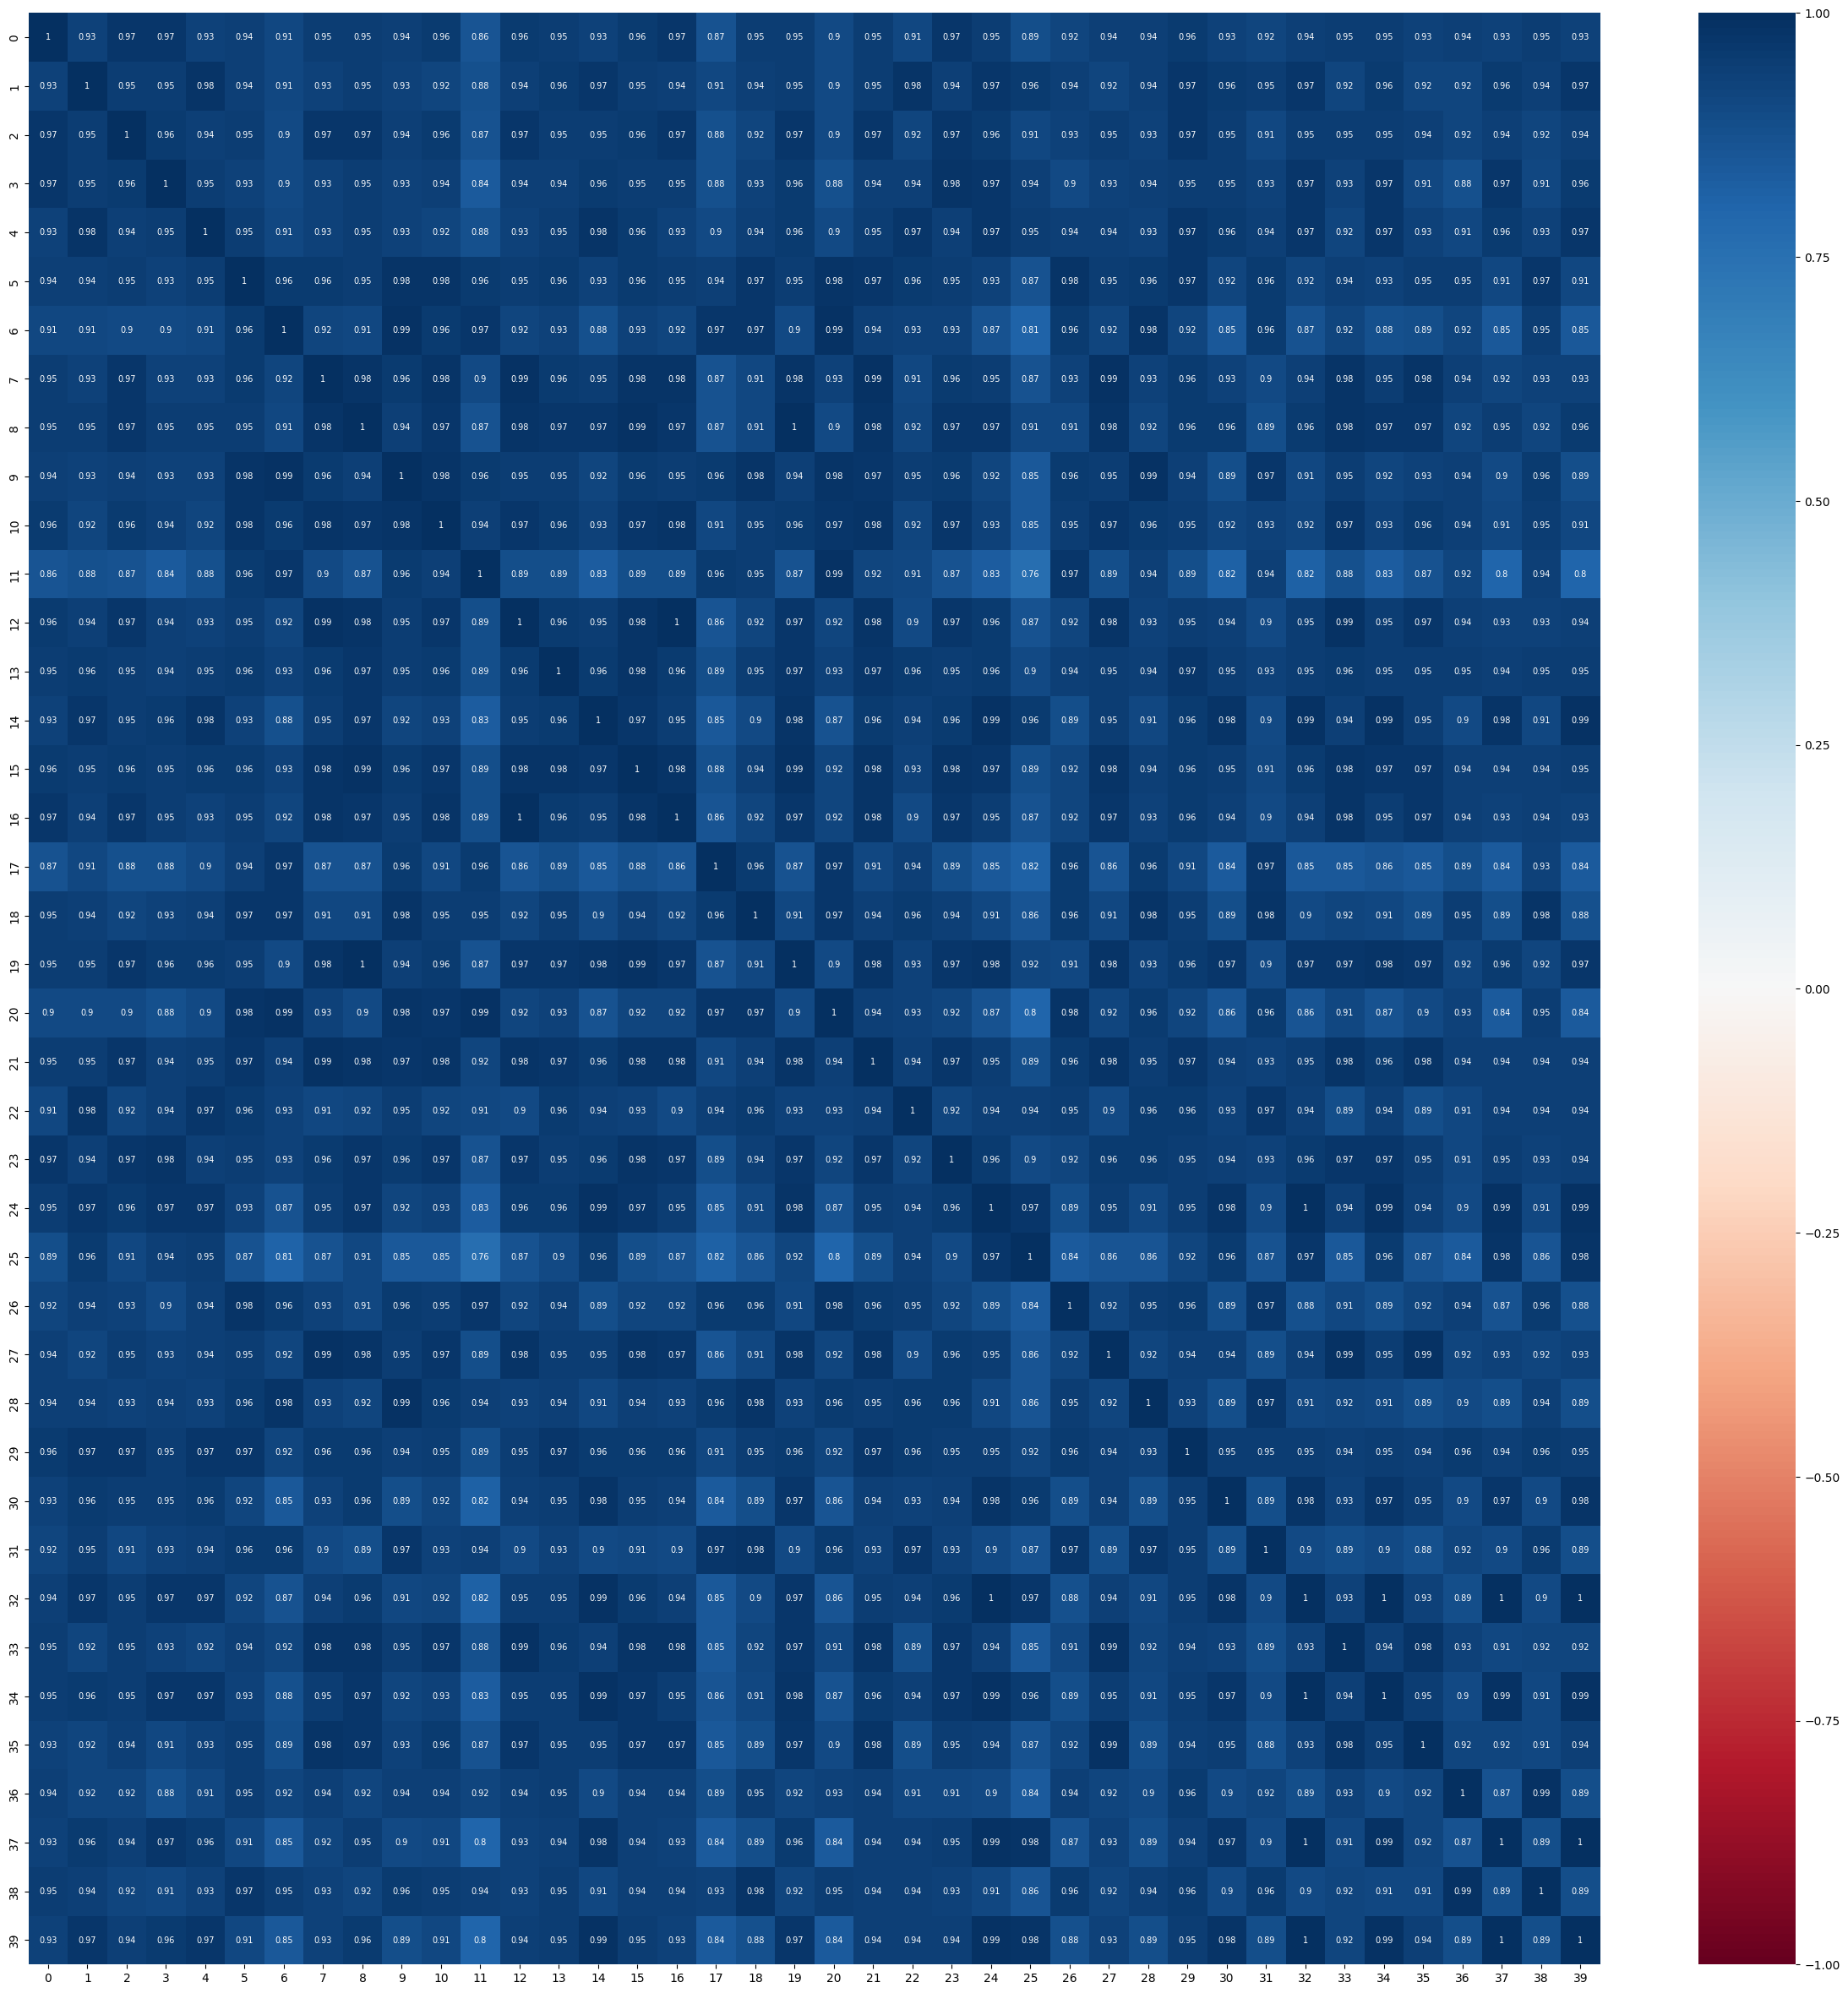

In [ ]:
ecg200ppv = pd.DataFrame(x_transformado[:,0:100:2].T)
plt.figure(figsize=(30,30))
correlations1 = ecg200ppv.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

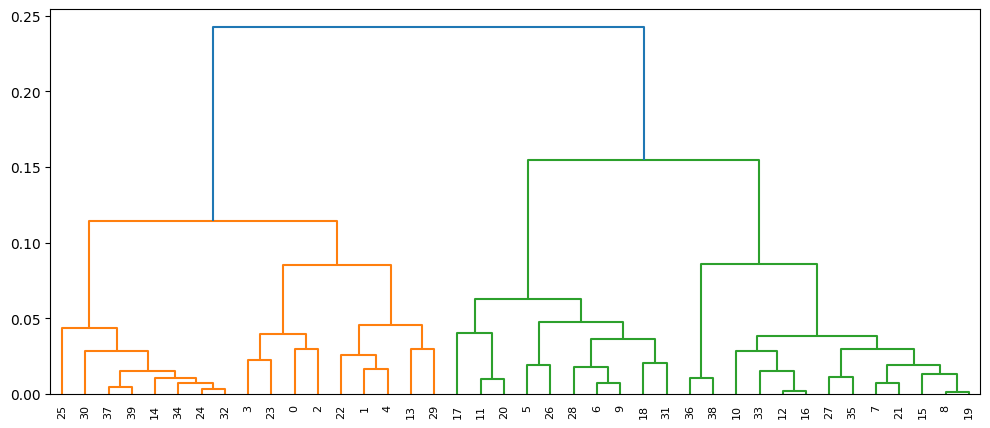

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity1 = 1 - abs(correlations1)
Z = linkage(squareform(dissimilarity1), 'complete')

dendrogram(Z, labels=ecg200ppv.columns, orientation='top',
           leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.000005 #dissimilaridade (distancia) entre dois clusters
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([11, 13, 12,  9, 14, 21, 23, 36, 38, 24, 33, 18, 30, 16,  6, 40, 31,
       20, 26, 39, 19, 37, 15, 10,  3,  8, 22, 34, 25, 17,  7, 27,  4, 32,
        5, 35, 28,  1, 29,  2], dtype=int32)

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200ppv.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200ppv[i])
    else:
        df_to_append = pd.DataFrame(ecg200ppv[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

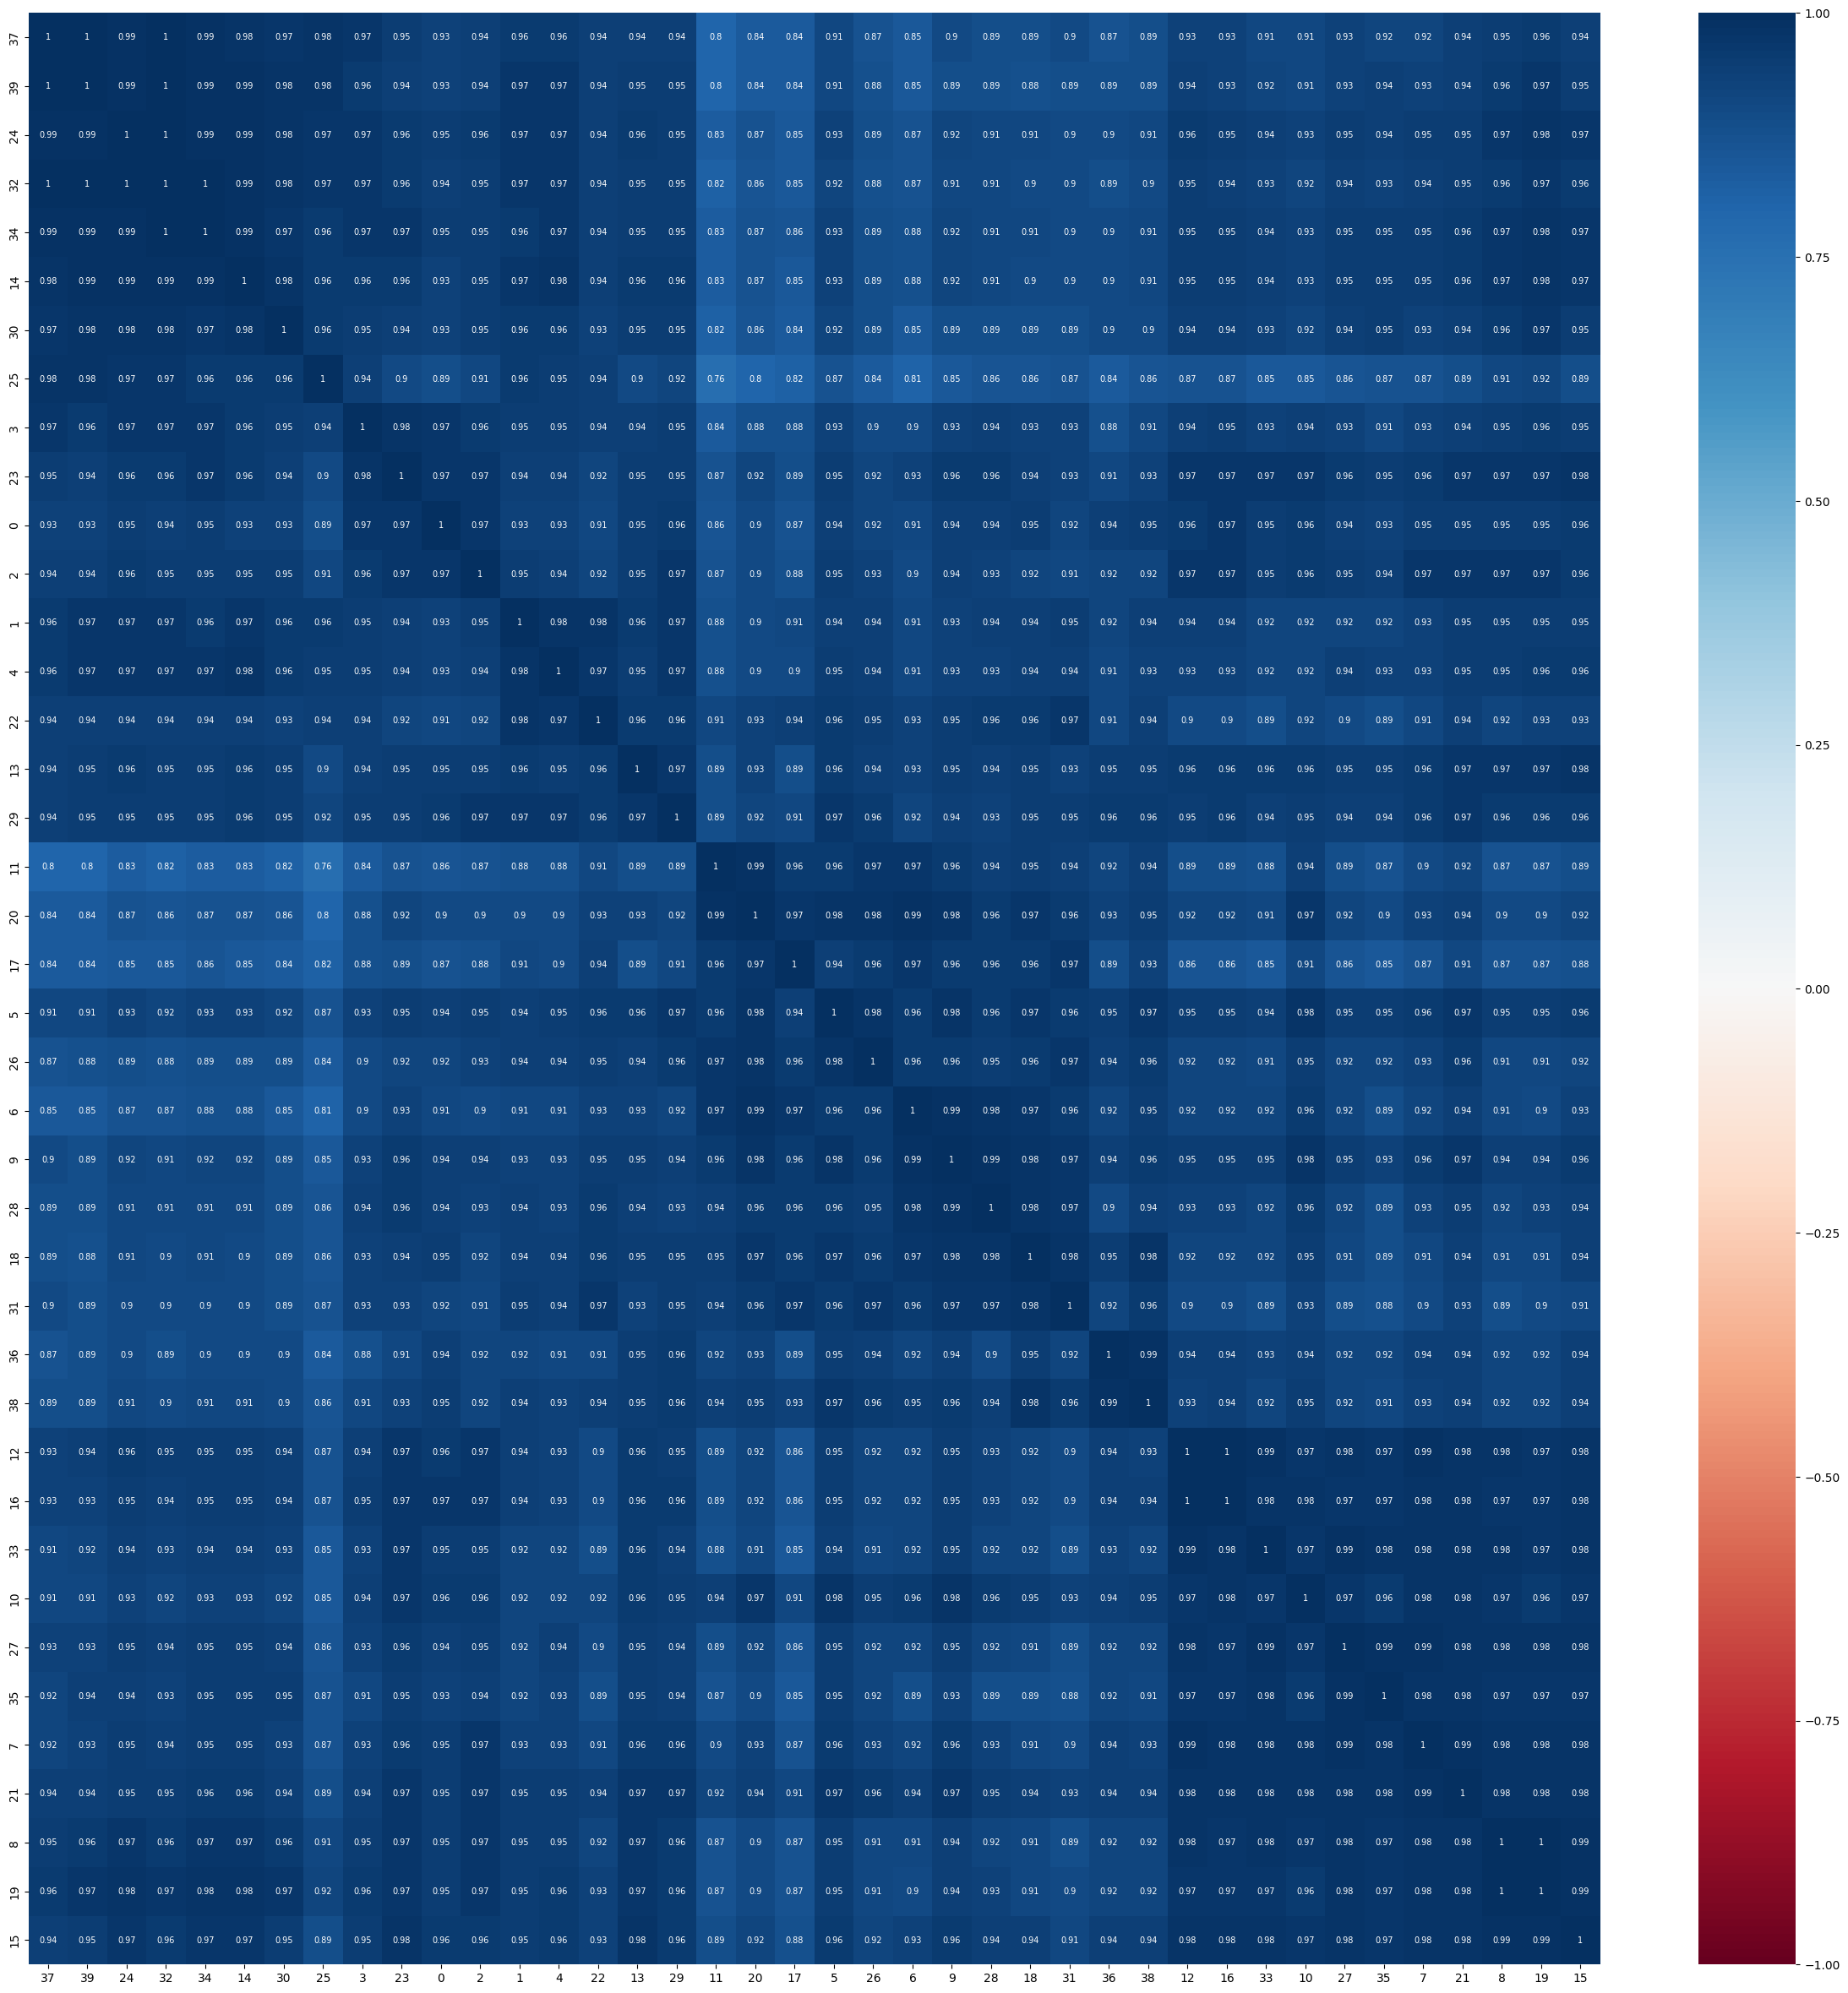

In [ ]:
plt.figure(figsize=(30,30))
correlations1 = clustered.corr()
sns.heatmap(round(correlations1,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

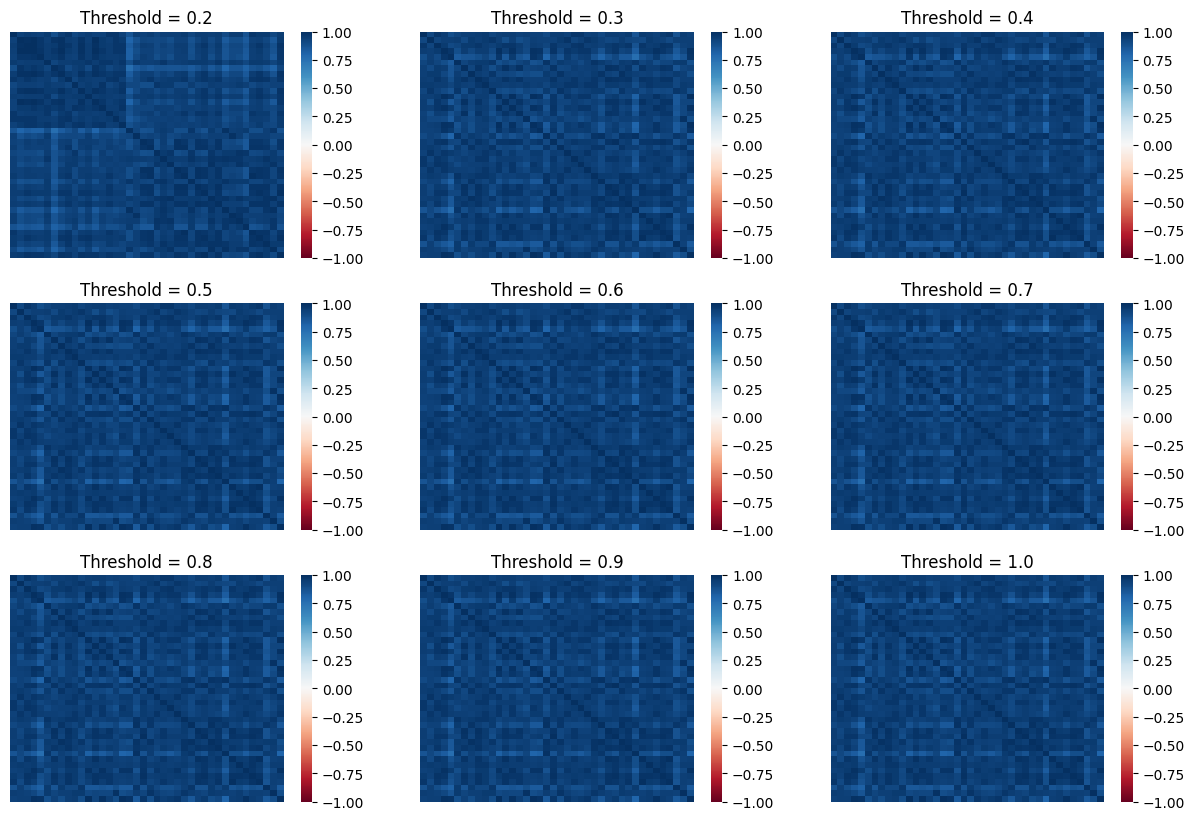

In [ ]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200ppv.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200ppv[i])
        else:
            df_to_append = pd.DataFrame(ecg200ppv[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations1 = clustered.corr()
    sns.heatmap(round(correlations1,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

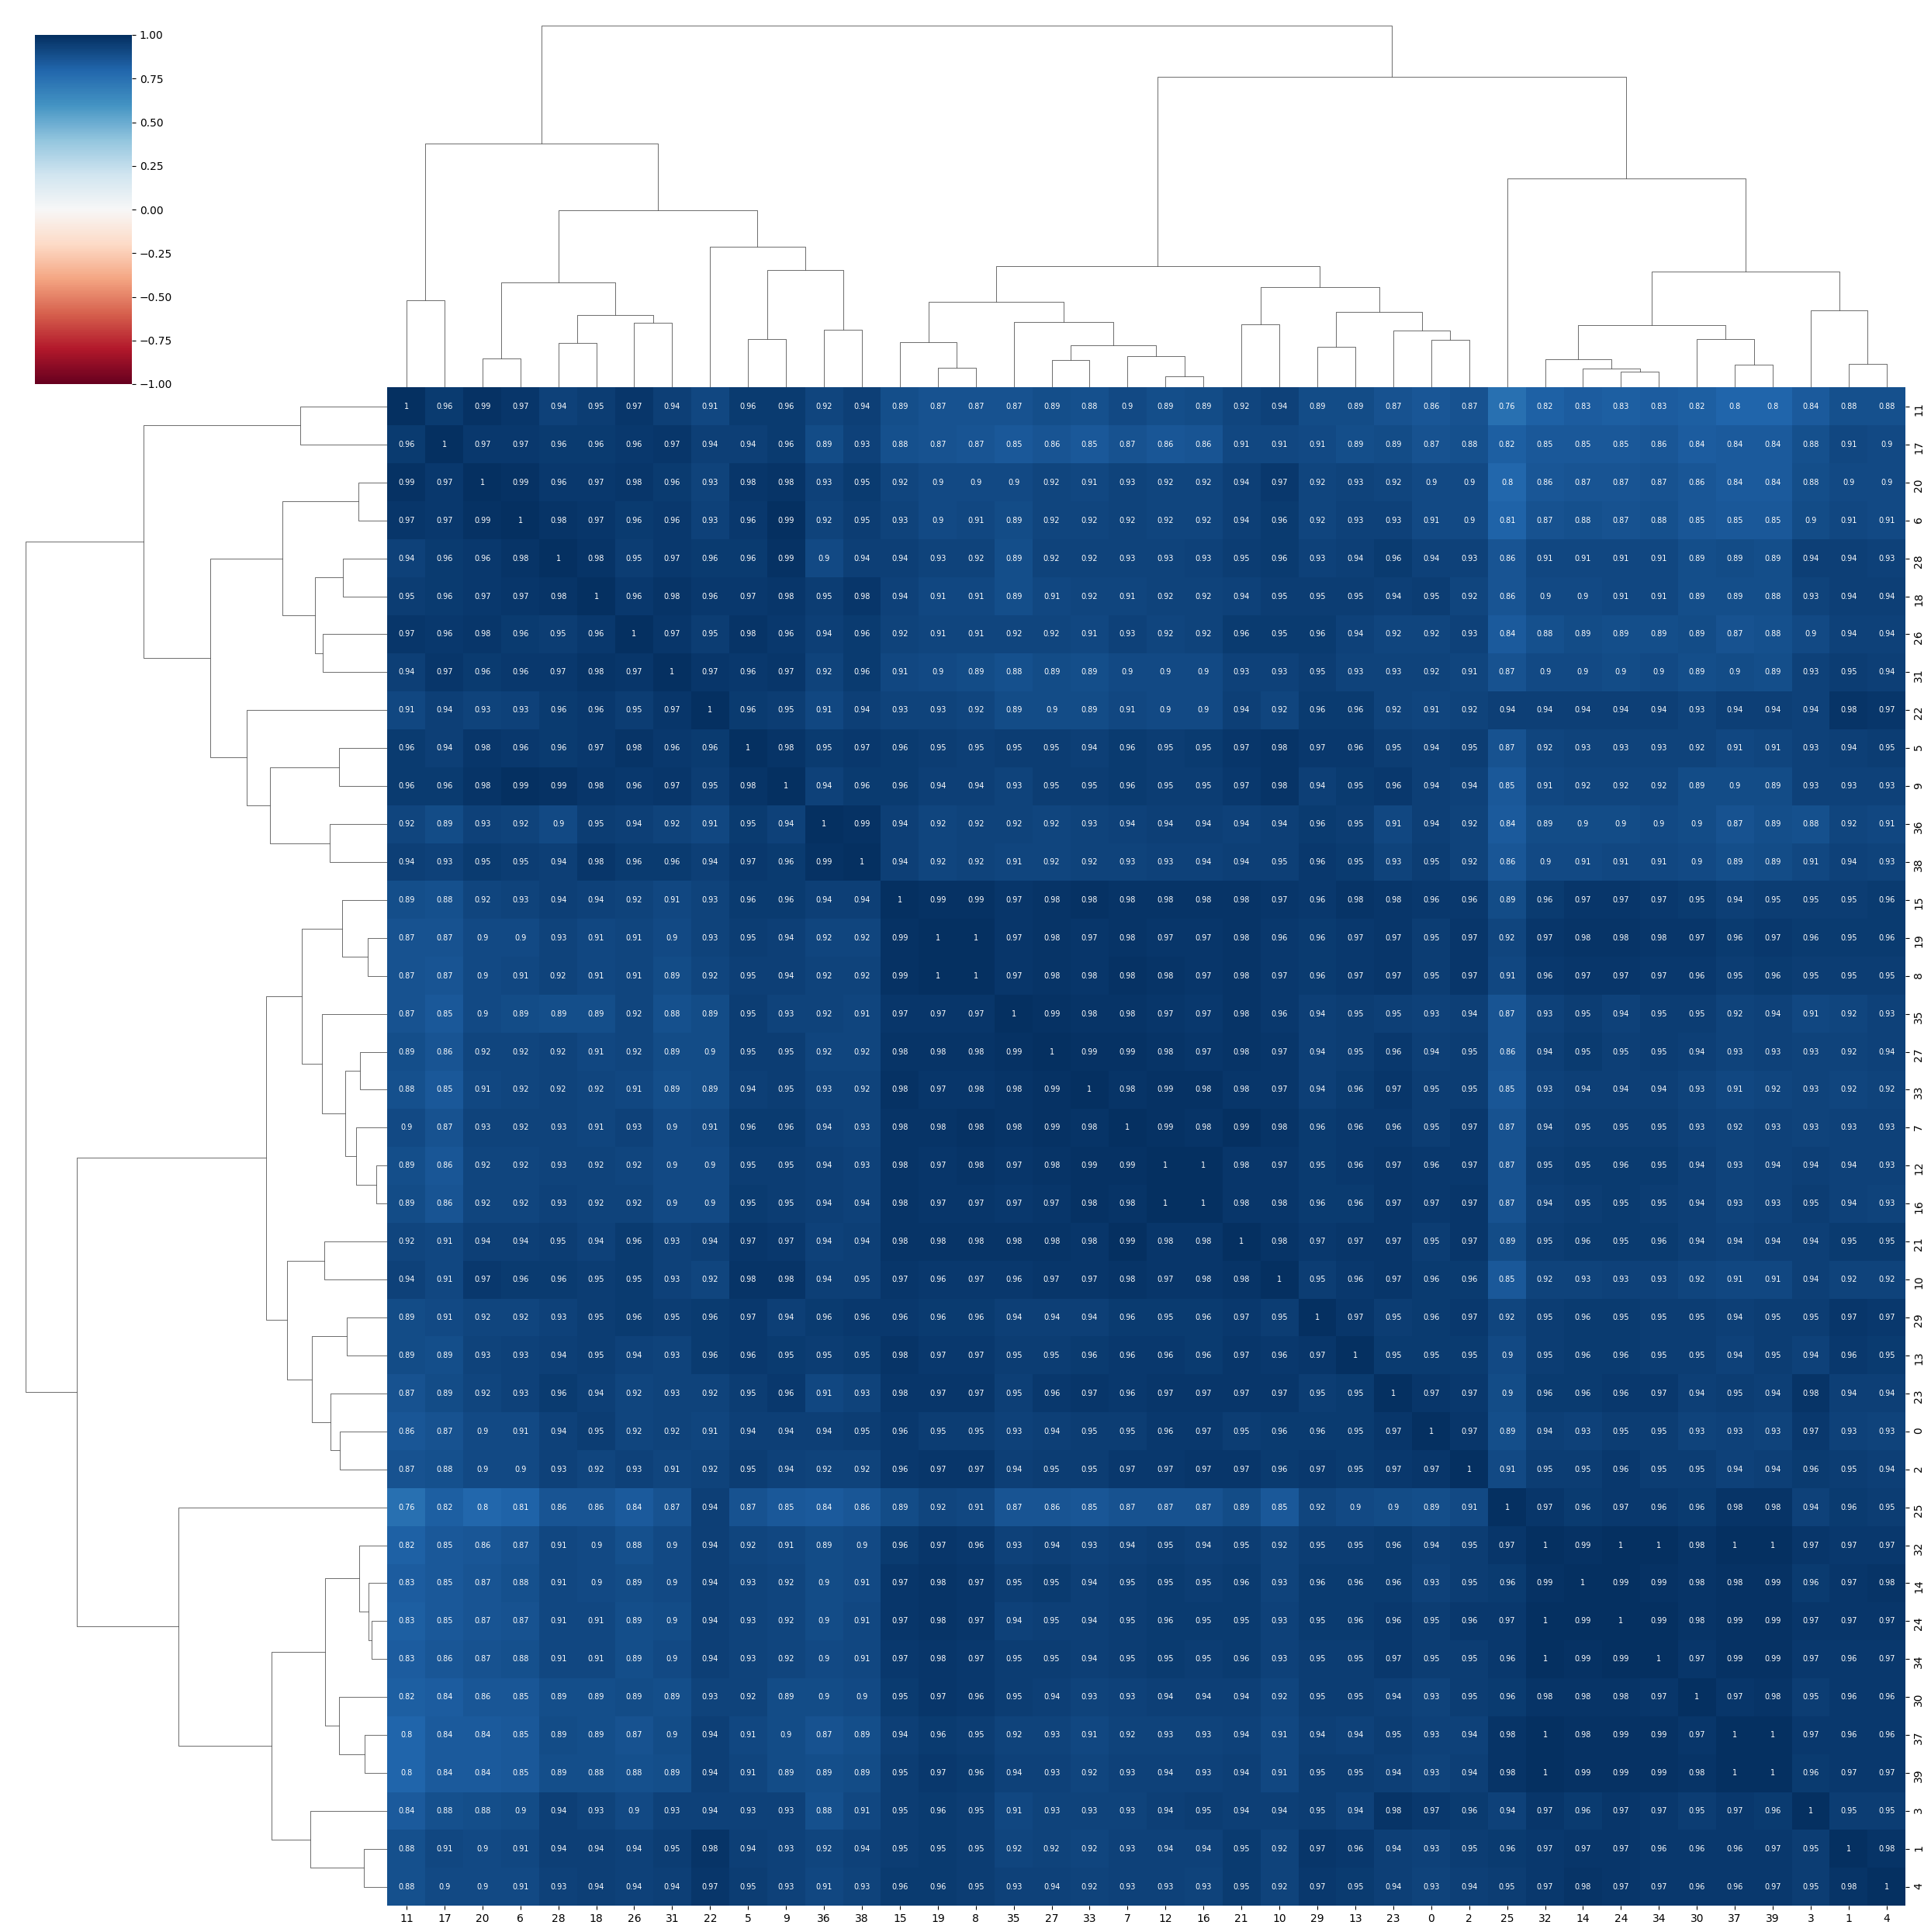

In [ ]:
sns.clustermap(correlations1, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));

<function matplotlib.pyplot.show(close=None, block=None)>

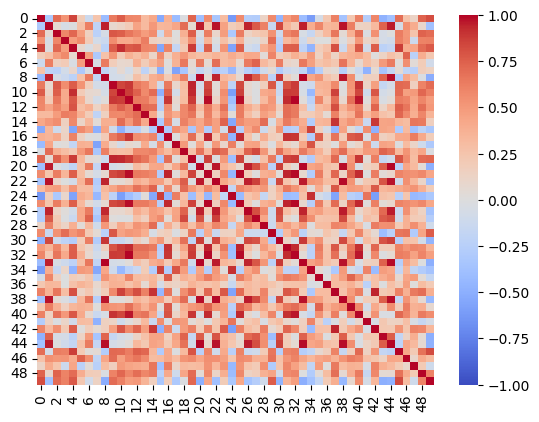

In [ ]:
#Análise dos valores do MAX
correlation_matrix2 = np.corrcoef(x_transformado[:,1:100:2].T)#todas as linhas, colunas de 1 a 36 pulando de 2 em 2(1,3,5,7,.. ímpares valores MAX)
sns.heatmap(correlation_matrix2, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show

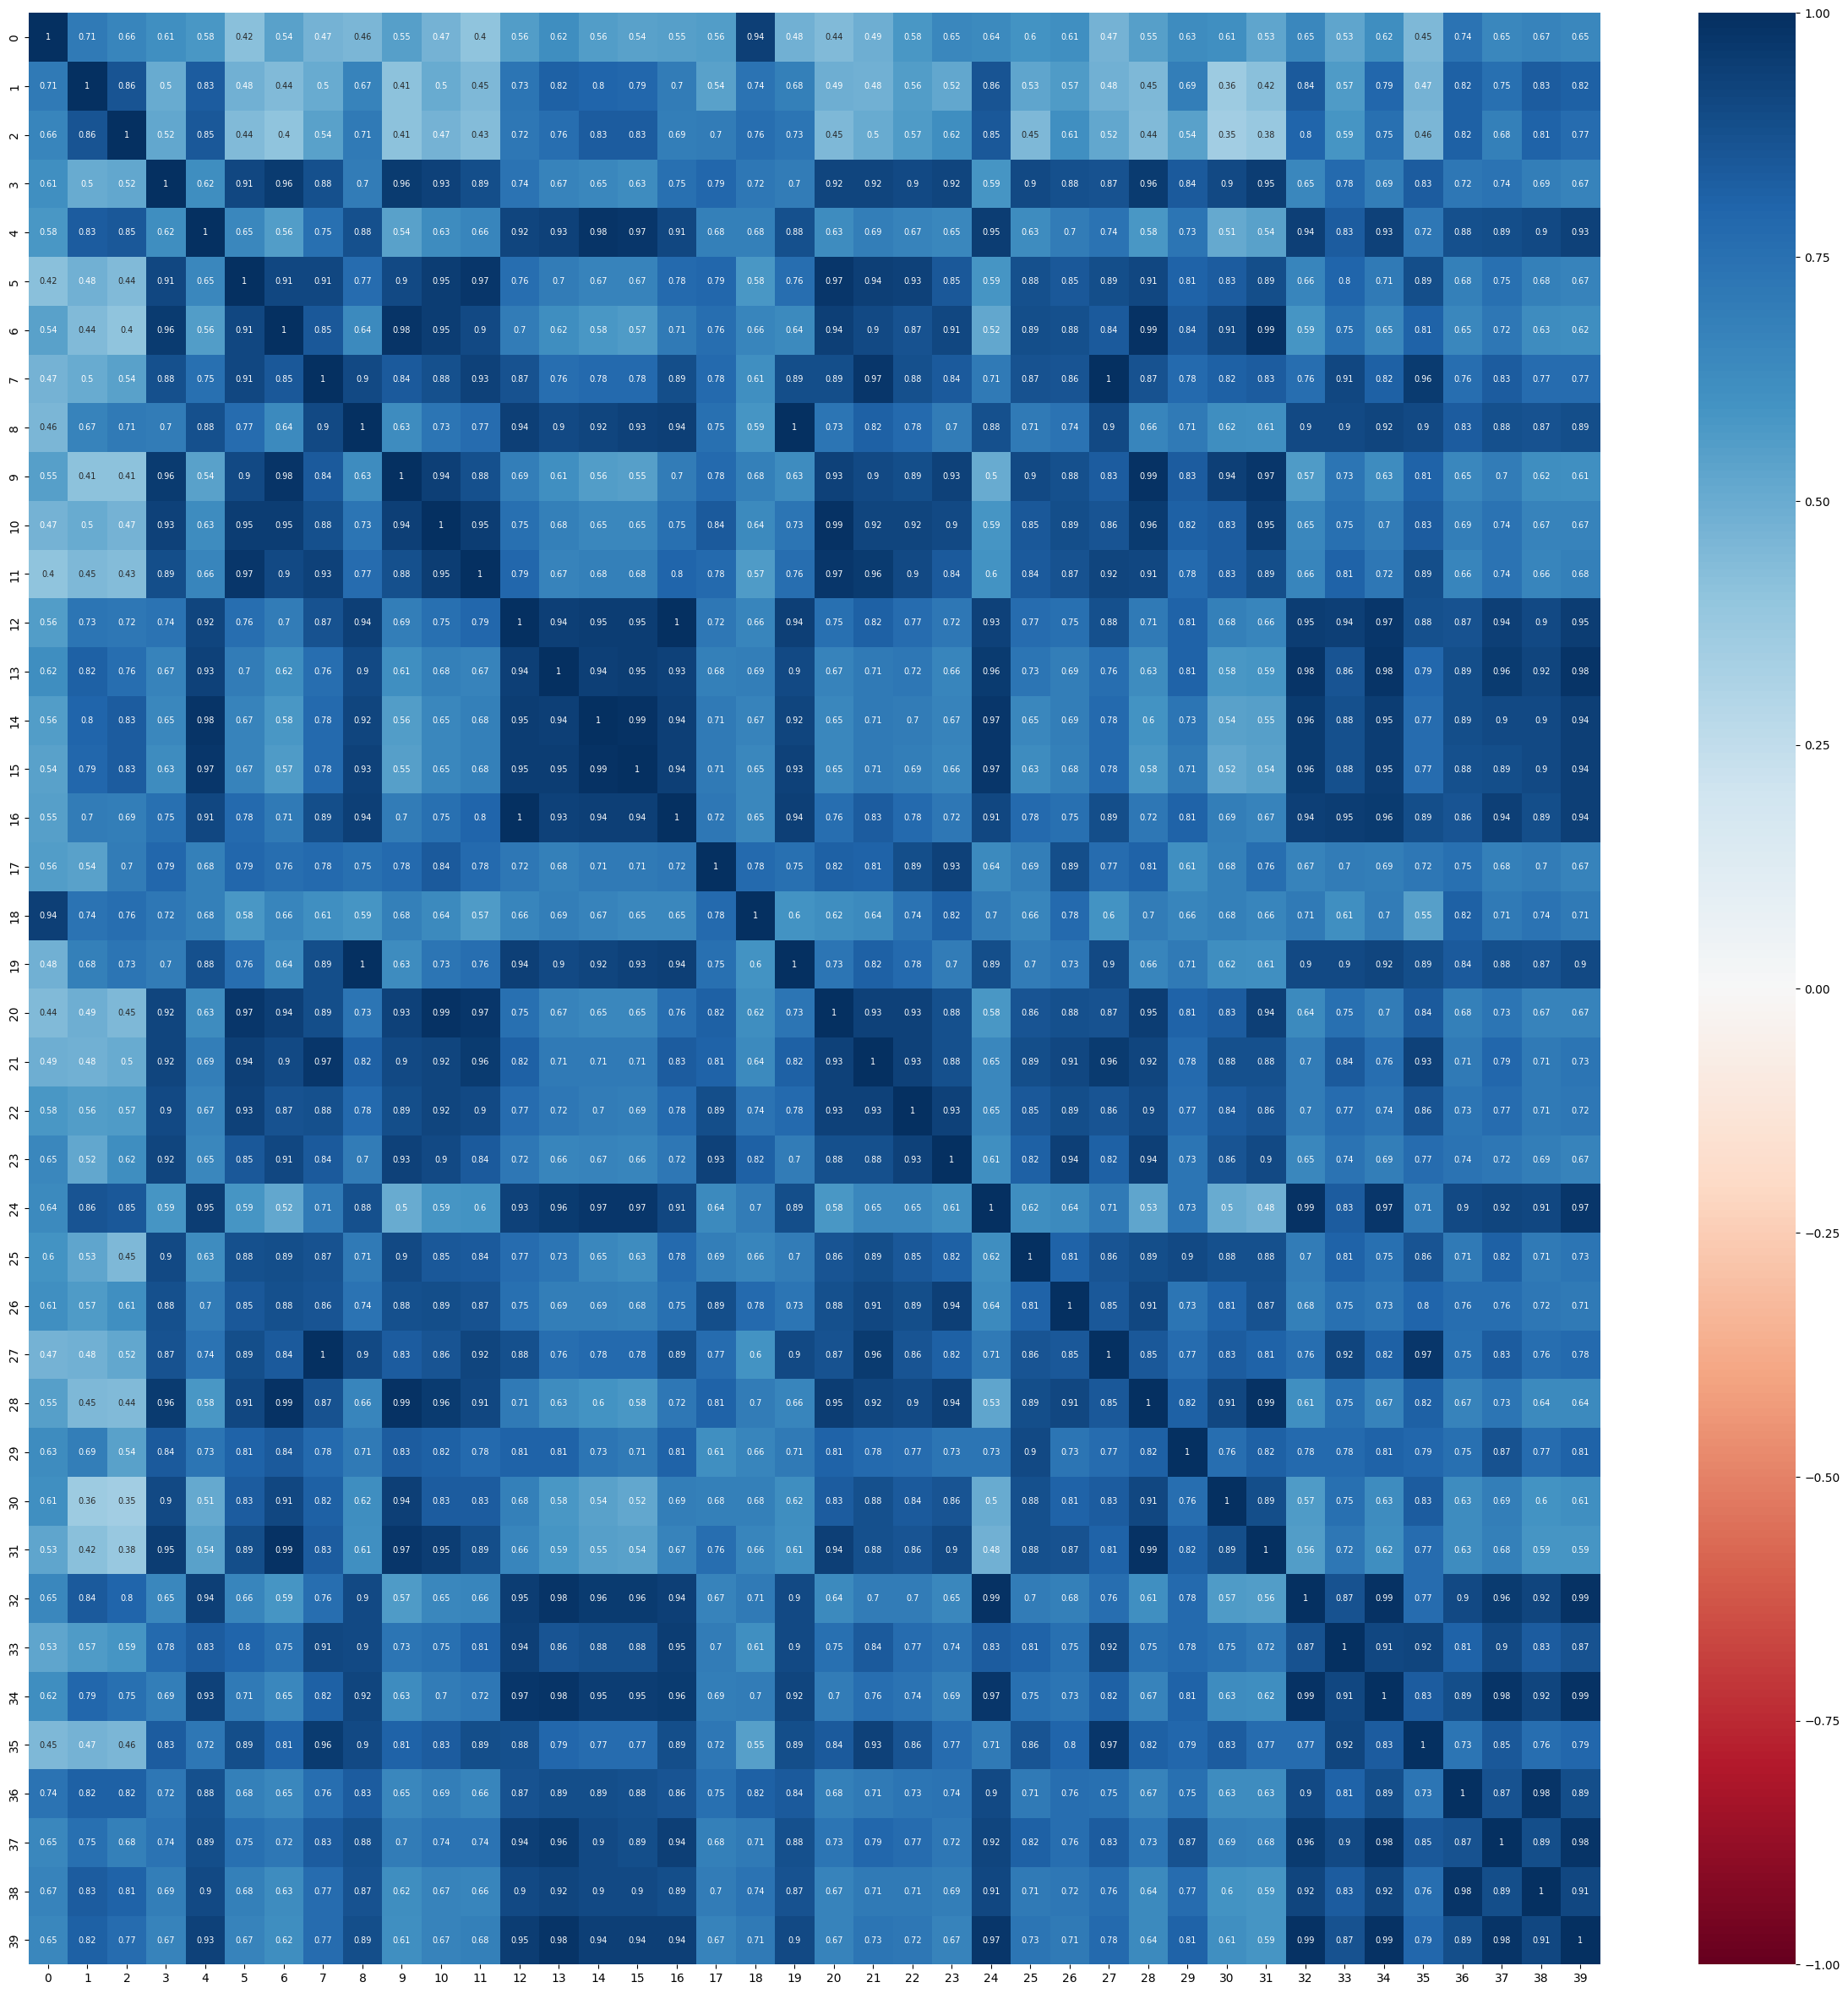

In [ ]:
ecg200max = pd.DataFrame(x_transformado[:,1:100:2].T)
plt.figure(figsize=(30,30))
correlations2 = ecg200max.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

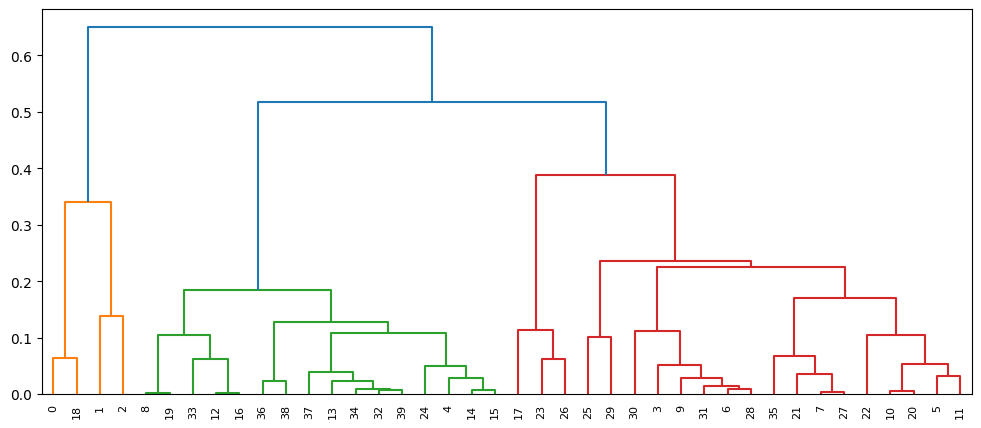

In [ ]:
plt.figure(figsize=(12,5))
dissimilarity2 = 1 - abs(correlations2)
Z = linkage(squareform(dissimilarity2), 'complete')

dendrogram(Z, labels=ecg200max.columns, orientation='top',
           leaf_rotation=90);

In [ ]:
# Clusterize the data
threshold = 0.000005
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([ 1,  3,  4, 30, 19, 38, 26, 32,  5, 29, 36, 39,  7, 15, 17, 18,  8,
       23,  2,  6, 37, 34, 40, 21, 20, 24, 22, 33, 27, 25, 31, 28, 12,  9,
       14, 35, 10, 16, 11, 13], dtype=int32)

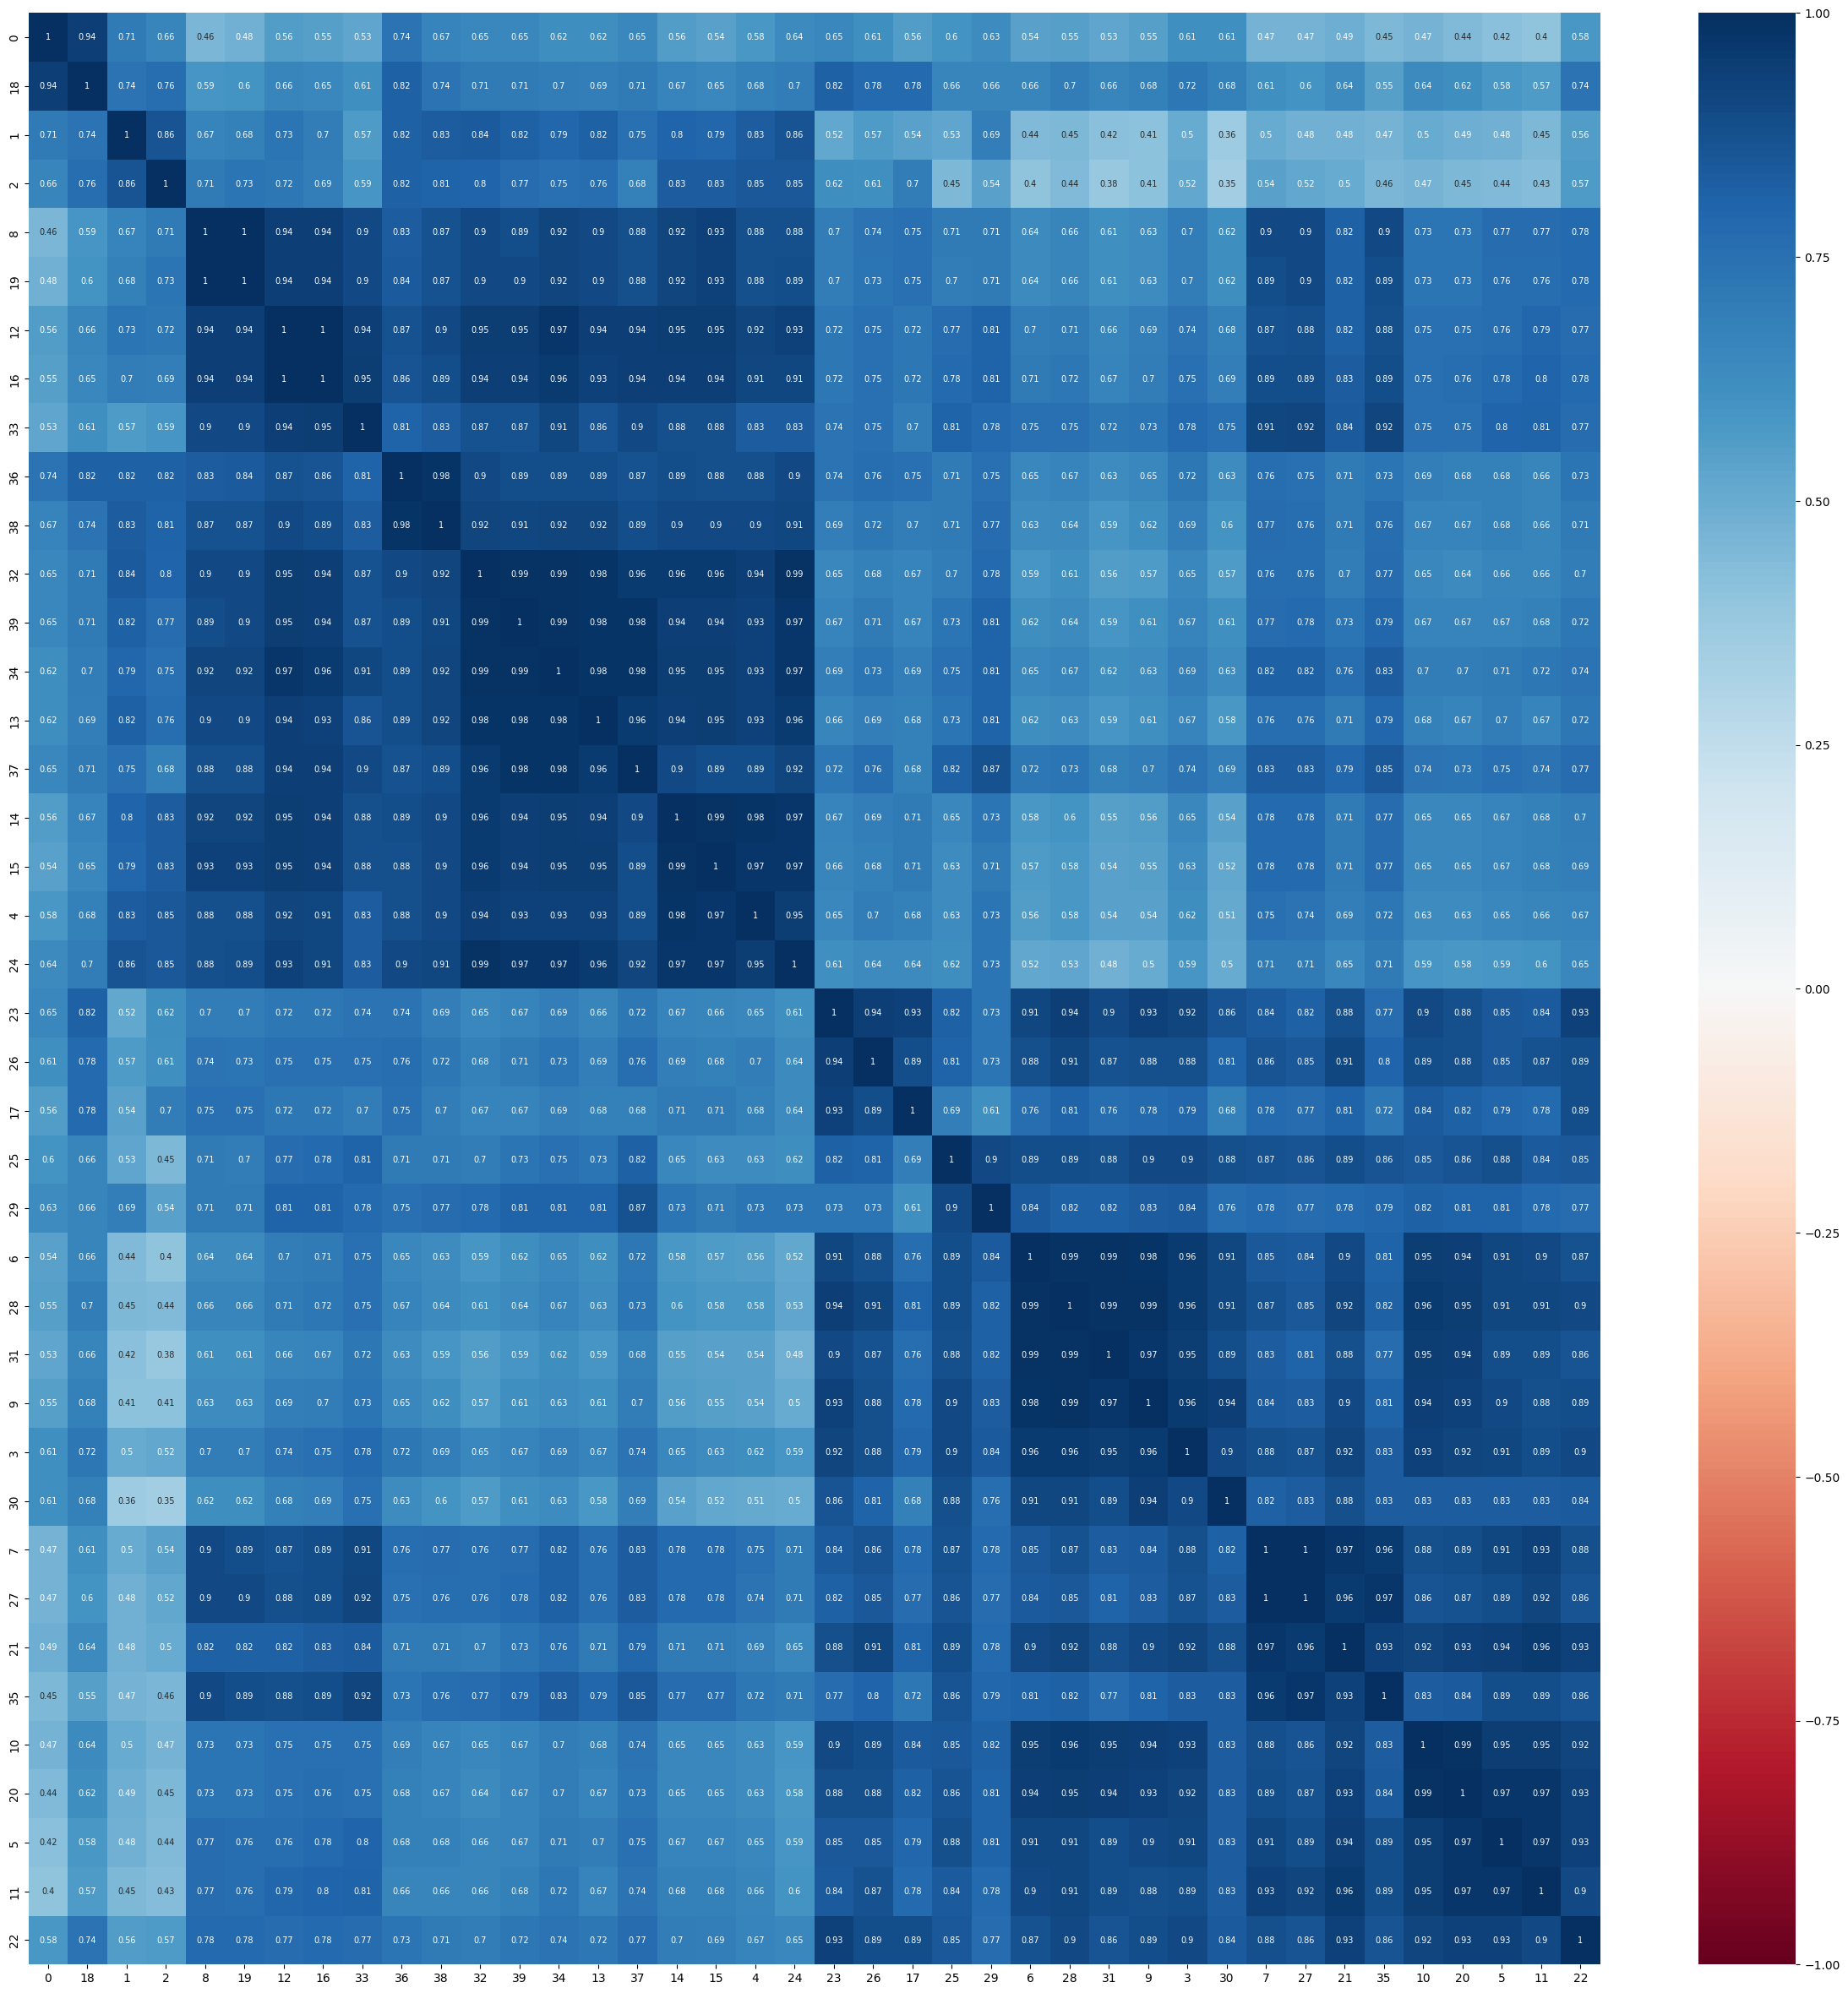

In [ ]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(ecg200max.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(ecg200max[i])
    else:
        df_to_append = pd.DataFrame(ecg200max[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(30,30))
correlations2 = clustered.corr()
sns.heatmap(round(correlations2,2), cmap='RdBu', annot=True,
            annot_kws={"size": 7}, vmin=-1, vmax=1);

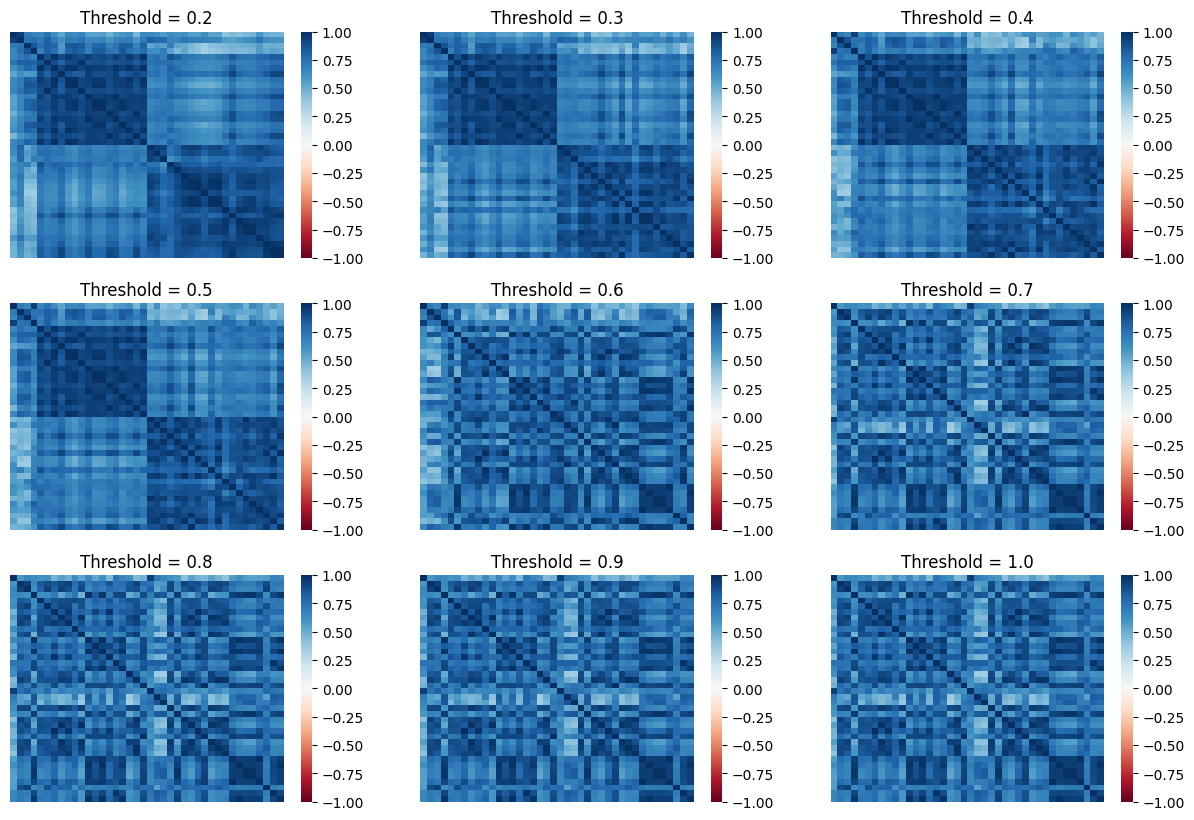

In [ ]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):

    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)

    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(ecg200max.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(ecg200max[i])
        else:
            df_to_append = pd.DataFrame(ecg200max[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    # Plot the correlation heatmap
    correlations2 = clustered.corr()
    sns.heatmap(round(correlations2,2), cmap='RdBu', vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))

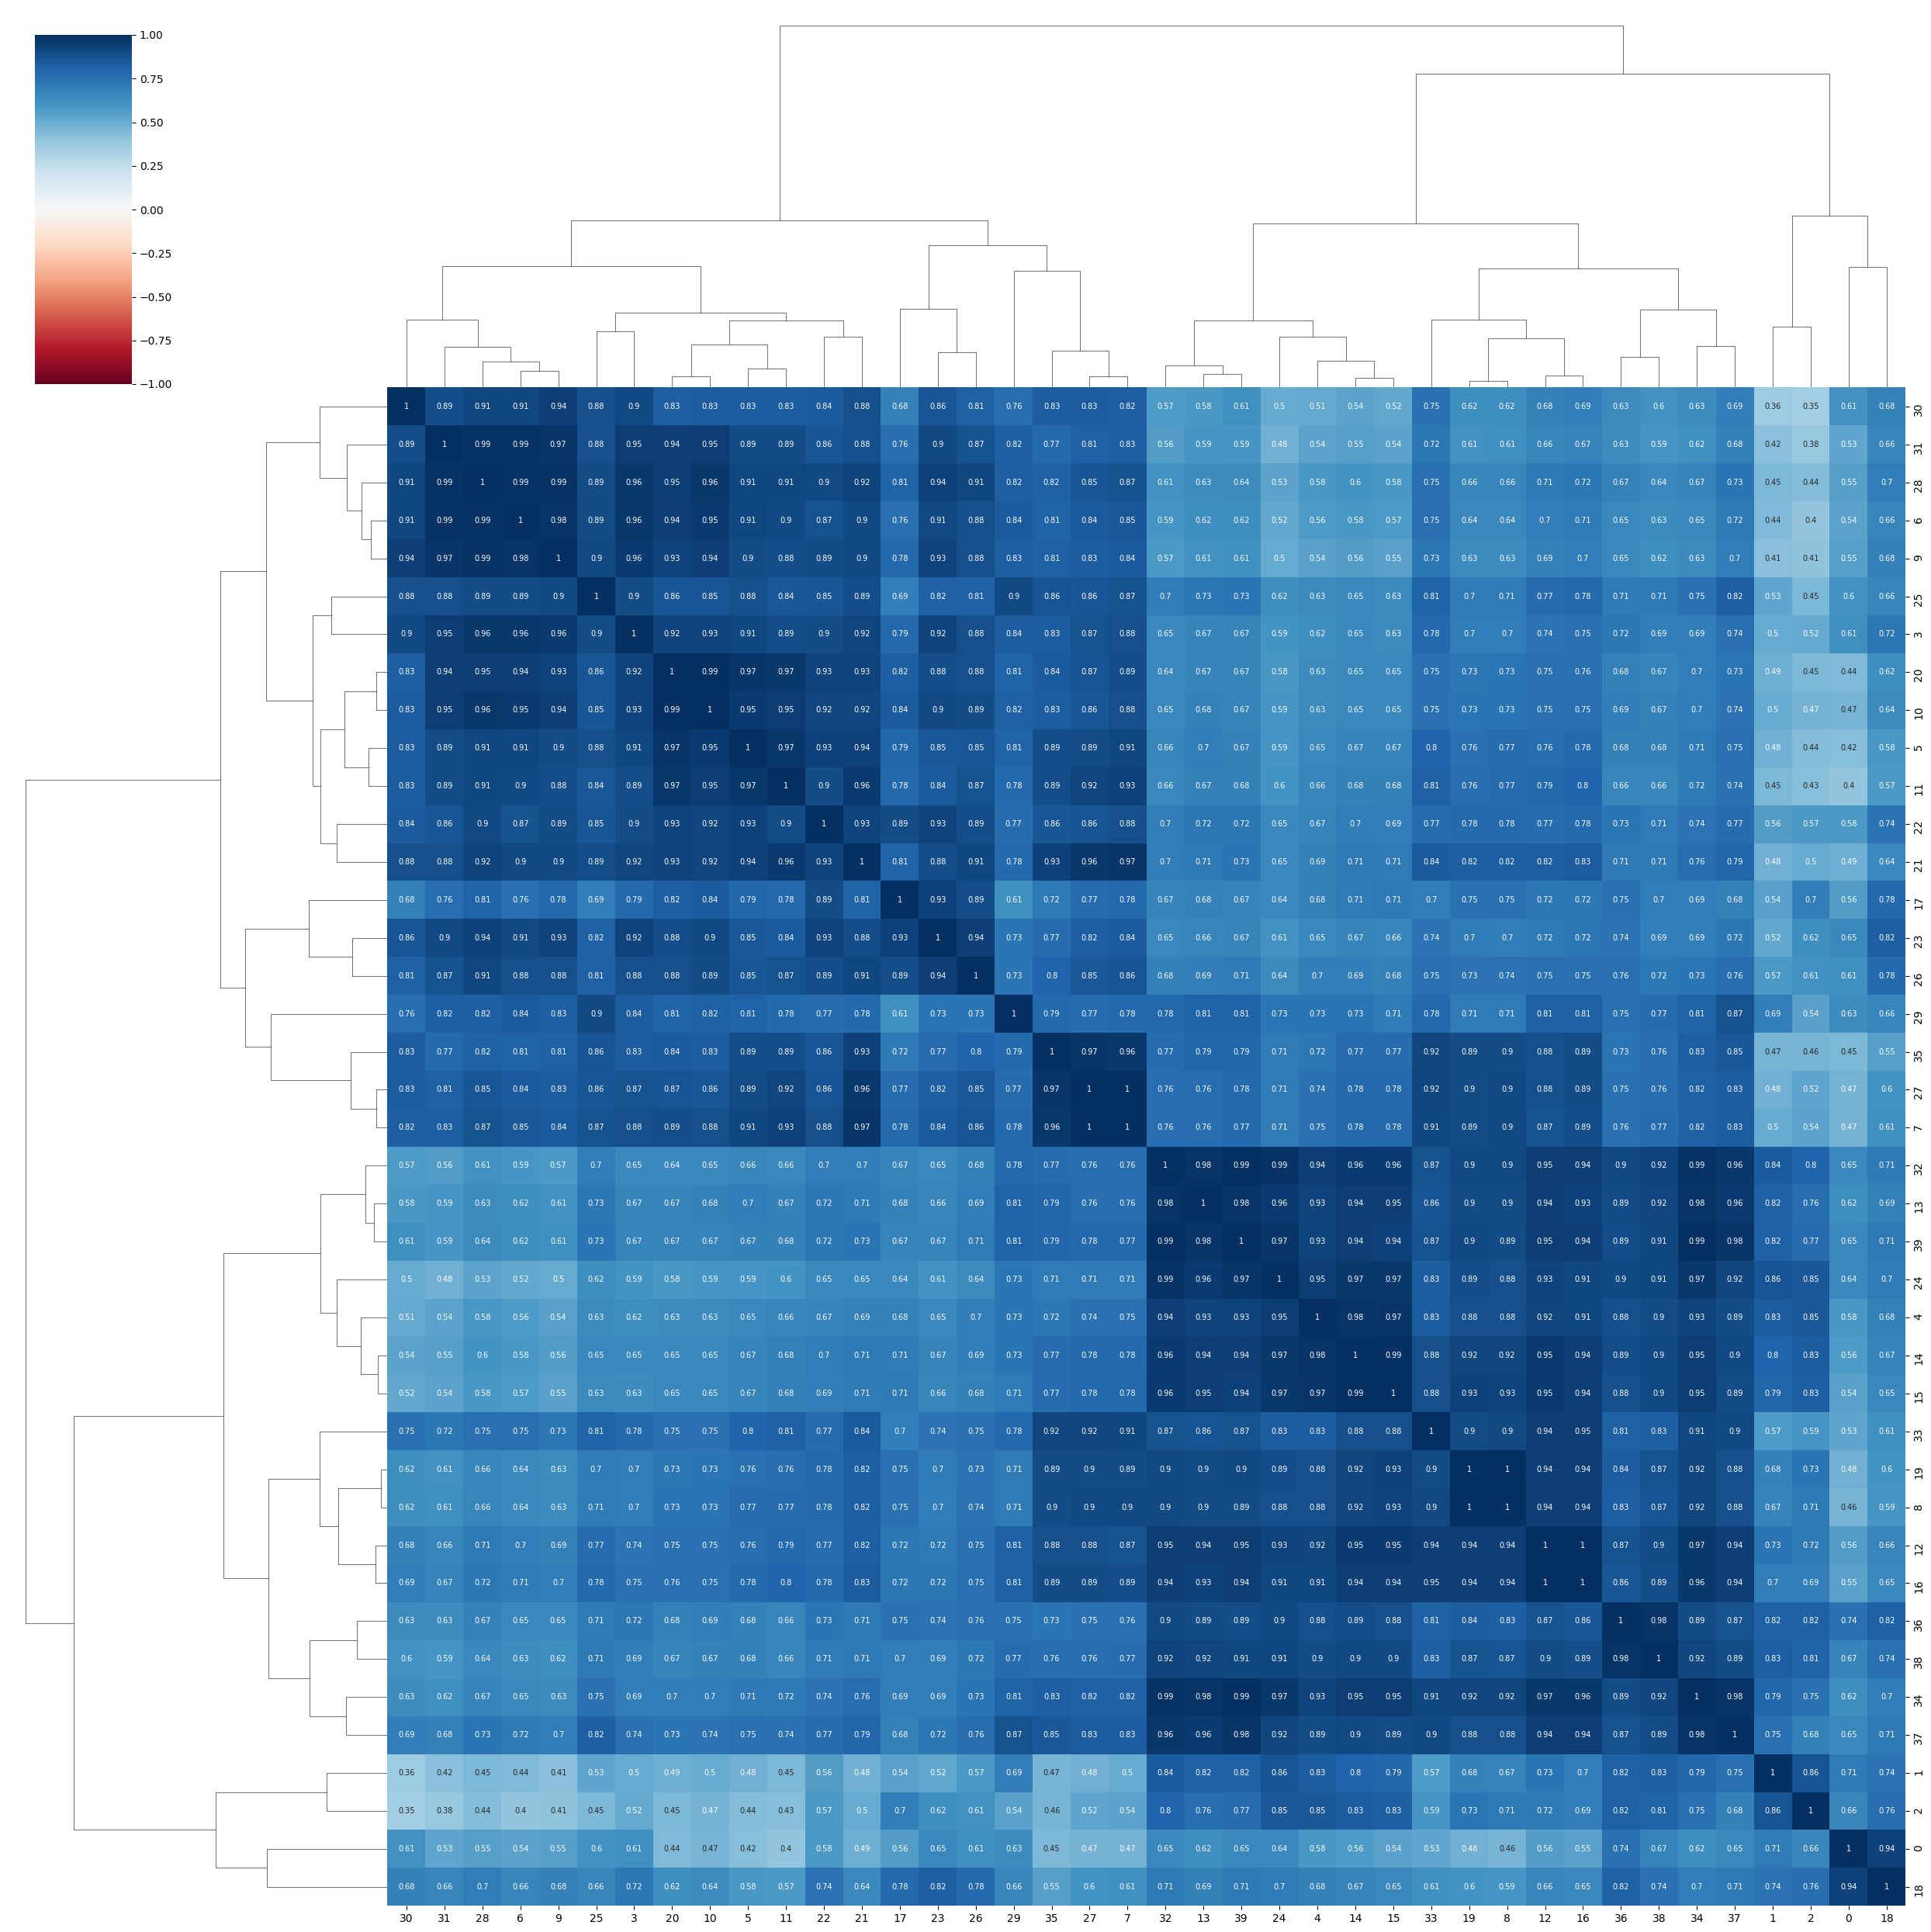

In [ ]:
sns.clustermap(correlations2, method="complete", cmap='RdBu', annot=True,
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(25,25));